# Feature Engineering for Steam Game Recommendation System

## Overview
This notebook builds the features required for three recommendation tasks:

### Task 1: Next-Game Purchase Prediction
- User-game interaction matrix
- Game popularity features
- Bundle-based similarity features

### Task 2: Bundle Completion
- Partial bundle ownership patterns
- Bundle-game mapping matrix
- Bundle similarity features

### Task 3: Cross-Bundle Discovery
- Bundle-bundle similarity matrix
- Shared game features
- Genre/theme overlap features

**Data Sources**: Processed from Steam EDA (games, users, bundles)

## 1. Setup and Data Loading

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import gzip
import ast
import pickle
from collections import defaultdict, Counter
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# Set up visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [2]:
# Load the data (reuse loading function from EDA)
data_dir = './data'

def load_json_gz(filepath, max_lines=None):
    """Load JSON lines from gzipped file"""
    data = []
    with gzip.open(filepath, 'rt', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if max_lines and i >= max_lines:
                break
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                try:
                    data.append(ast.literal_eval(line))
                except (ValueError, SyntaxError):
                    continue
    return data

print("Loading datasets...")
print("-" * 60)

# Load all datasets
games_data = load_json_gz(f'{data_dir}/steam_games.json.gz')
games_df = pd.DataFrame(games_data)
print(f"✓ Loaded {len(games_df):,} games")

users_data = load_json_gz(f'{data_dir}/australian_users_items.json.gz')
print(f"✓ Loaded {len(users_data):,} users")

bundles_data = load_json_gz(f'{data_dir}/bundle_data.json.gz')
bundles_df = pd.DataFrame(bundles_data)
print(f"✓ Loaded {len(bundles_df):,} bundles")

print("-" * 60)
print("Data loaded successfully!")

Loading datasets...
------------------------------------------------------------
✓ Loaded 32,135 games
✓ Loaded 32,135 games
✓ Loaded 88,310 users
✓ Loaded 615 bundles
------------------------------------------------------------
Data loaded successfully!
✓ Loaded 88,310 users
✓ Loaded 615 bundles
------------------------------------------------------------
Data loaded successfully!


## 2. Build User-Game Interaction Matrix

Create a sparse matrix representing which users own which games. This is the foundation for collaborative filtering.

In [3]:
# Extract all user-game interactions
all_interactions = []
for user in users_data:
    user_id = user.get('user_id', user.get('steam_id'))
    for item in user.get('items', []):
        item_id = item.get('item_id', item.get('app_id'))
        playtime = item.get('playtime_forever', 0)
        all_interactions.append({
            'user_id': user_id,
            'item_id': str(item_id),
            'playtime': playtime,
            'owned': 1
        })

interactions_df = pd.DataFrame(all_interactions)

print("=" * 60)
print("USER-GAME INTERACTIONS")
print("=" * 60)
print(f"Total interactions: {len(interactions_df):,}")
print(f"Unique users: {interactions_df['user_id'].nunique():,}")
print(f"Unique games: {interactions_df['item_id'].nunique():,}")
print(f"Sparsity: {(1 - len(interactions_df) / (interactions_df['user_id'].nunique() * interactions_df['item_id'].nunique())) * 100:.2f}%")

USER-GAME INTERACTIONS
Total interactions: 5,153,209
Unique users: 70,912
Unique games: 10,978
Unique games: 10,978
Sparsity: 99.34%
Sparsity: 99.34%


In [4]:
# Create ID mappings
user_ids = sorted(interactions_df['user_id'].unique())
item_ids = sorted(interactions_df['item_id'].unique())

user_to_idx = {user: idx for idx, user in enumerate(user_ids)}
idx_to_user = {idx: user for user, idx in user_to_idx.items()}

item_to_idx = {item: idx for idx, item in enumerate(item_ids)}
idx_to_item = {idx: item for item, idx in item_to_idx.items()}

print(f"Created mappings:")
print(f"  Users: {len(user_to_idx):,}")
print(f"  Games: {len(item_to_idx):,}")

# Build sparse user-item matrix
row_indices = [user_to_idx[user] for user in interactions_df['user_id']]
col_indices = [item_to_idx[item] for item in interactions_df['item_id']]
data = interactions_df['owned'].values

user_item_matrix = csr_matrix(
    (data, (row_indices, col_indices)),
    shape=(len(user_ids), len(item_ids))
)

print(f"\n✓ User-Item Matrix Shape: {user_item_matrix.shape}")
print(f"✓ Non-zero elements: {user_item_matrix.nnz:,}")
print(f"✓ Memory size: {user_item_matrix.data.nbytes / 1e6:.2f} MB")

Created mappings:
  Users: 70,912
  Games: 10,978

✓ User-Item Matrix Shape: (70912, 10978)
✓ Non-zero elements: 5,094,082
✓ Memory size: 40.75 MB

✓ User-Item Matrix Shape: (70912, 10978)
✓ Non-zero elements: 5,094,082
✓ Memory size: 40.75 MB


## 3. Build Bundle-Game Mapping Matrix

Create a matrix showing which games appear in which bundles - critical for bundle-based recommendations.

In [5]:
# Find the column containing bundle items
bundle_item_col = None
for col in bundles_df.columns:
    if len(bundles_df) > 0:
        sample_val = bundles_df[col].iloc[0]
        if isinstance(sample_val, list) and len(sample_val) > 0:
            if isinstance(sample_val[0], dict):
                bundle_item_col = col
                break

print("=" * 60)
print("BUNDLE-GAME MAPPING")
print("=" * 60)
print(f"Bundle items column: '{bundle_item_col}'")

# Extract bundle-game relationships
bundle_game_pairs = []
bundle_info = []

for idx, row in bundles_df.iterrows():
    bundle_id = row.get('id', row.get('bundle_id', idx))
    bundle_name = row.get('bundle_name', row.get('name', f'Bundle_{idx}'))
    
    if bundle_item_col and isinstance(row[bundle_item_col], list):
        items = row[bundle_item_col]
        bundle_games = []
        
        for item in items:
            if isinstance(item, dict):
                item_id = str(item.get('item_id', item.get('app_id', '')))
                item_name = item.get('item_name', item.get('name', ''))
                
                if item_id:
                    bundle_games.append(item_id)
                    bundle_game_pairs.append({
                        'bundle_id': bundle_id,
                        'bundle_name': bundle_name,
                        'item_id': item_id,
                        'item_name': item_name
                    })
        
        bundle_info.append({
            'bundle_id': bundle_id,
            'bundle_name': bundle_name,
            'num_games': len(bundle_games),
            'games': bundle_games
        })

bundle_game_df = pd.DataFrame(bundle_game_pairs)
bundle_info_df = pd.DataFrame(bundle_info)

print(f"\nTotal bundle-game pairs: {len(bundle_game_df):,}")
print(f"Unique bundles: {bundle_game_df['bundle_id'].nunique():,}")
print(f"Unique games in bundles: {bundle_game_df['item_id'].nunique():,}")
print(f"\nBundle size statistics:")
print(f"  Mean: {bundle_info_df['num_games'].mean():.2f} games")
print(f"  Median: {bundle_info_df['num_games'].median():.2f} games")
print(f"  Max: {bundle_info_df['num_games'].max()} games")

BUNDLE-GAME MAPPING
Bundle items column: 'items'

Total bundle-game pairs: 3,515
Unique bundles: 613
Unique games in bundles: 2,797

Bundle size statistics:
  Mean: 5.72 games
  Median: 3.00 games
  Max: 88 games


In [6]:
# Create bundle-game sparse matrix
bundle_ids = sorted(bundle_game_df['bundle_id'].unique())
bundle_to_idx = {bundle: idx for idx, bundle in enumerate(bundle_ids)}
idx_to_bundle = {idx: bundle for bundle, idx in bundle_to_idx.items()}

# Only include games that exist in our item_to_idx mapping
valid_bundle_game_df = bundle_game_df[bundle_game_df['item_id'].isin(item_to_idx.keys())].copy()

bundle_row_indices = [bundle_to_idx[bid] for bid in valid_bundle_game_df['bundle_id']]
game_col_indices = [item_to_idx[gid] for gid in valid_bundle_game_df['item_id']]
bundle_data = [1] * len(valid_bundle_game_df)

bundle_game_matrix = csr_matrix(
    (bundle_data, (bundle_row_indices, game_col_indices)),
    shape=(len(bundle_ids), len(item_ids))
)

print(f"\n✓ Bundle-Game Matrix Shape: {bundle_game_matrix.shape}")
print(f"✓ Non-zero elements: {bundle_game_matrix.nnz:,}")
print(f"✓ Games per bundle (avg): {bundle_game_matrix.sum(axis=1).mean():.2f}")


✓ Bundle-Game Matrix Shape: (613, 10978)
✓ Non-zero elements: 1,834
✓ Games per bundle (avg): 2.99


## 4. Calculate Game-Game Similarity

Compute similarity between games based on:
1. Bundle co-occurrence (games appearing in same bundles)
2. User co-purchase (users owning both games)

In [7]:
print("=" * 60)
print("GAME-GAME SIMILARITY CALCULATION")
print("=" * 60)

# Method 1: Bundle co-occurrence similarity (KEEP SPARSE)
# Games that appear together in bundles are similar
print("\n1. Computing bundle-based similarity...")
bundle_game_normalized = normalize(bundle_game_matrix, norm='l2', axis=0)
bundle_similarity = (bundle_game_normalized.T @ bundle_game_normalized)  # Keep sparse!
print(f"   ✓ Bundle similarity matrix shape: {bundle_similarity.shape}")
print(f"   ✓ Sparsity: {(1 - bundle_similarity.nnz / (bundle_similarity.shape[0] * bundle_similarity.shape[1])) * 100:.2f}%")
print(f"   ✓ Memory: {bundle_similarity.data.nbytes / 1e6:.2f} MB")

# Method 2: User co-purchase similarity (KEEP SPARSE)
# Games owned by the same users are similar
print("\n2. Computing user co-purchase similarity...")
# Normalize user-item matrix along users, then compute item-item similarity
user_item_normalized = normalize(user_item_matrix, norm='l2', axis=1)
copurchase_similarity = (user_item_normalized.T @ user_item_normalized)  # Keep sparse!
print(f"   ✓ Co-purchase similarity matrix shape: {copurchase_similarity.shape}")
print(f"   ✓ Sparsity: {(1 - copurchase_similarity.nnz / (copurchase_similarity.shape[0] * copurchase_similarity.shape[1])) * 100:.2f}%")
print(f"   ✓ Memory: {copurchase_similarity.data.nbytes / 1e6:.2f} MB")

# Combine both similarities (weighted average) - STAY SPARSE
alpha = 0.6  # Weight for bundle similarity (hypothesis: bundles are stronger signal)
combined_similarity = alpha * bundle_similarity + (1 - alpha) * copurchase_similarity

print(f"  Bundle weight: {alpha}, Co-purchase weight: {1-alpha}")

print(f"\n✓ Combined similarity matrix created (SPARSE)")
print(f"  Memory size: {combined_similarity.data.nbytes / 1e6:.2f} MB")

print(f"  Shape: {combined_similarity.shape}")
print(f"  Non-zero elements: {combined_similarity.nnz:,}")

GAME-GAME SIMILARITY CALCULATION

1. Computing bundle-based similarity...
   ✓ Bundle similarity matrix shape: (10978, 10978)
   ✓ Sparsity: 99.99%
   ✓ Memory: 0.13 MB

2. Computing user co-purchase similarity...
   ✓ Co-purchase similarity matrix shape: (10978, 10978)
   ✓ Sparsity: 29.44%
   ✓ Memory: 680.30 MB
   ✓ Co-purchase similarity matrix shape: (10978, 10978)
   ✓ Sparsity: 29.44%
   ✓ Memory: 680.30 MB
  Bundle weight: 0.6, Co-purchase weight: 0.4

✓ Combined similarity matrix created (SPARSE)
  Memory size: 680.31 MB
  Shape: (10978, 10978)
  Non-zero elements: 85,038,518
  Bundle weight: 0.6, Co-purchase weight: 0.4

✓ Combined similarity matrix created (SPARSE)
  Memory size: 680.31 MB
  Shape: (10978, 10978)
  Non-zero elements: 85,038,518


## 4.5 Calculate Game Popularity (needed for visualization)

In [8]:
# Calculate popularity for each game (needed for sampling in visualization)
game_popularity = user_item_matrix.sum(axis=0).A1
game_popularity_df = pd.DataFrame({
    'item_idx': range(len(item_ids)),
    'item_id': [idx_to_item[i] for i in range(len(item_ids))],
    'num_owners': game_popularity,
    'popularity_rank': np.argsort(-game_popularity)
})
game_popularity_df['popularity_score'] = game_popularity_df['num_owners'] / game_popularity_df['num_owners'].max()

print(f"✓ Calculated popularity for {len(game_popularity_df):,} games (for sampling)")

✓ Calculated popularity for 10,978 games (for sampling)


SIMILARITY VISUALIZATION

Creating sample for visualization...
   ✓ Sampled top 1000 games for visualization


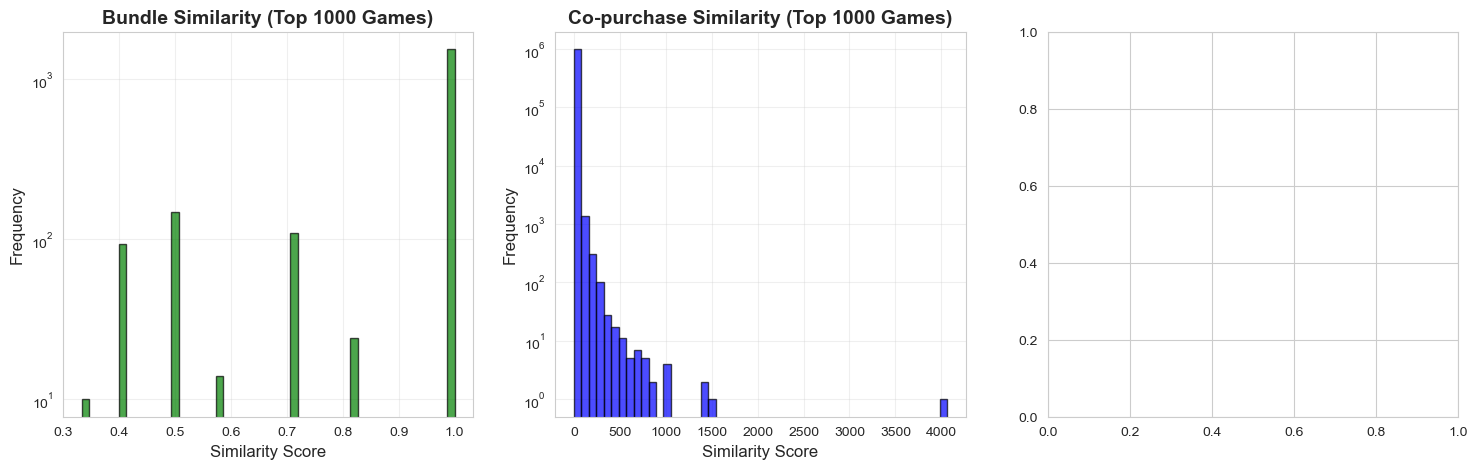

Text(1013.0212998334101, 0.5, 'Frequency')

<Figure size 1200x600 with 0 Axes>

In [11]:
# Visualize similarity distribution (sample to avoid memory issues)
print("=" * 60)
print("SIMILARITY VISUALIZATION")
print("=" * 60)
print("\nCreating sample for visualization...")
sample_size = 1000  # Top 1000 most popular games
top_games_idx = game_popularity_df.nlargest(sample_size, 'num_owners')['item_idx'].values

# Extract sparse submatrices and convert only the sample
bundle_sim_sample = bundle_similarity[top_games_idx][:, top_games_idx].toarray()
copurchase_sim_sample = copurchase_similarity[top_games_idx][:, top_games_idx].toarray()
combined_sim_sample = combined_similarity[top_games_idx][:, top_games_idx].toarray()
print(f"   ✓ Sampled top {sample_size} games for visualization")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Bundle similarity
bundle_sim_values = bundle_sim_sample[bundle_sim_sample > 0].flatten()
axes[0].hist(bundle_sim_values, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0].set_xlabel('Similarity Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title(f'Bundle Similarity (Top {sample_size} Games)', fontsize=14, fontweight='bold')
axes[0].set_yscale('log')
axes[0].grid(alpha=0.3)

# Co-purchase similarity
copurchase_sim_values = copurchase_sim_sample[copurchase_sim_sample > 0].flatten()
axes[1].hist(copurchase_sim_values, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[1].set_xlabel('Similarity Score', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title(f'Co-purchase Similarity (Top {sample_size} Games)', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')

axes[1].grid(alpha=0.3)
plt.show()

plt.tight_layout()

# Combined similarity

combined_sim_values = combined_sim_sample[combined_sim_sample > 0].flatten()
axes[2].grid(alpha=0.3)
axes[2].hist(combined_sim_values, bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[2].set_yscale('log')
axes[2].set_xlabel('Similarity Score', fontsize=12)
axes[2].set_title(f'Combined Similarity (Top {sample_size} Games)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Frequency', fontsize=12)

## 5. Generate Bundle Completion Features

For Task 2, identify users with partial bundle ownership and create features for recommendation.

In [12]:
print("=" * 60)
print("BUNDLE COMPLETION ANALYSIS")
print("=" * 60)

# For each user, check their ownership of games in each bundle
partial_bundles = []

for user_idx, user_id in enumerate(user_ids[:1000]):  # Sample for demonstration
    if user_idx % 200 == 0:
        print(f"Processing user {user_idx + 1}/1000...")
    
    # Get user's owned games
    user_games = set(user_item_matrix[user_idx].nonzero()[1])
    user_game_ids = {idx_to_item[idx] for idx in user_games}
    
    # Check each bundle
    for bundle_id, bundle_data in zip(bundle_ids, bundle_info_df.itertuples()):
        bundle_games = set(bundle_data.games)
        
        # Skip if bundle has no games in our item set
        if not bundle_games:
            continue
        
        # Calculate ownership
        owned_in_bundle = user_game_ids & bundle_games
        missing_in_bundle = bundle_games - user_game_ids
        
        ownership_ratio = len(owned_in_bundle) / len(bundle_games) if bundle_games else 0
        
        # Only consider partial ownership (not 0% or 100%)
        if 0 < ownership_ratio < 1:
            partial_bundles.append({
                'user_id': user_id,
                'bundle_id': bundle_id,
                'bundle_name': bundle_data.bundle_name,
                'total_games': len(bundle_games),
                'owned_games': len(owned_in_bundle),
                'missing_games': len(missing_in_bundle),
                'ownership_ratio': ownership_ratio,
                'missing_game_ids': list(missing_in_bundle)
            })

partial_bundles_df = pd.DataFrame(partial_bundles)

print(f"\n✓ Found {len(partial_bundles_df):,} partial bundle ownerships")
print(f"\nOwnership ratio distribution:")
print(partial_bundles_df['ownership_ratio'].describe())

BUNDLE COMPLETION ANALYSIS
Processing user 1/1000...
Processing user 201/1000...
Processing user 401/1000...
Processing user 601/1000...
Processing user 801/1000...

✓ Found 12,277 partial bundle ownerships

Ownership ratio distribution:
count    12277.000000
mean         0.285829
std          0.206262
min          0.011364
25%          0.111111
50%          0.250000
75%          0.500000
max          0.895833
Name: ownership_ratio, dtype: float64
Processing user 601/1000...
Processing user 801/1000...

✓ Found 12,277 partial bundle ownerships

Ownership ratio distribution:
count    12277.000000
mean         0.285829
std          0.206262
min          0.011364
25%          0.111111
50%          0.250000
75%          0.500000
max          0.895833
Name: ownership_ratio, dtype: float64


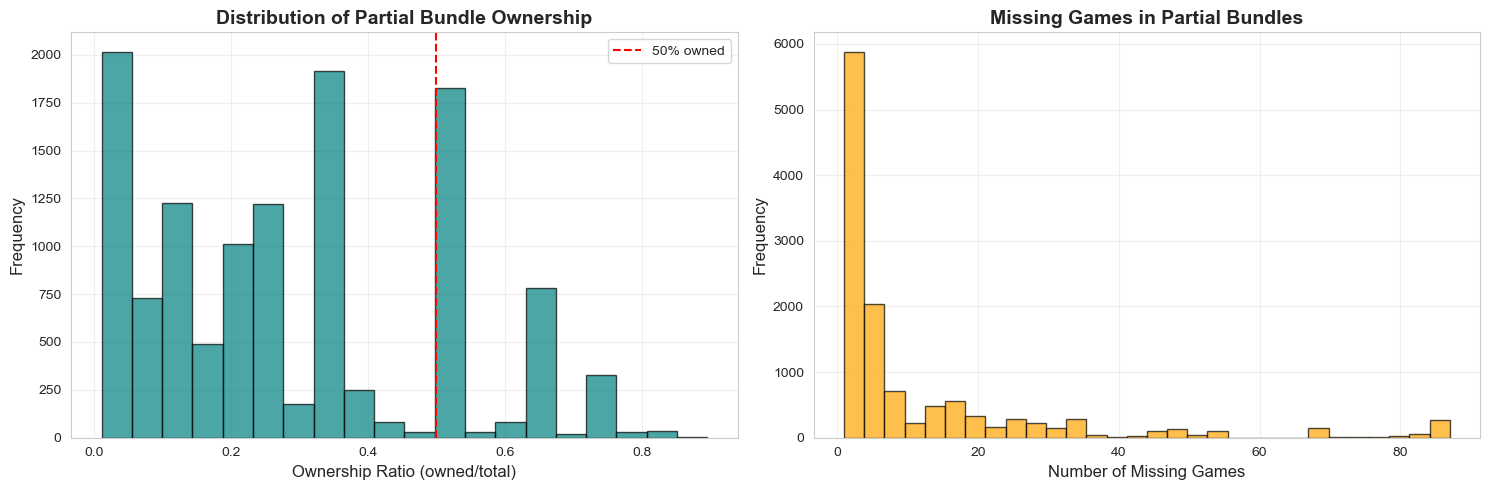


High-confidence recommendations (>50% owned):
  1,340 cases (10.9%)


In [13]:
# Visualize partial bundle ownership patterns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Ownership ratio distribution
axes[0].hist(partial_bundles_df['ownership_ratio'], bins=20, edgecolor='black', alpha=0.7, color='teal')
axes[0].set_xlabel('Ownership Ratio (owned/total)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Partial Bundle Ownership', fontsize=14, fontweight='bold')
axes[0].axvline(0.5, color='red', linestyle='--', label='50% owned')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Number of missing games
axes[1].hist(partial_bundles_df['missing_games'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Number of Missing Games', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Missing Games in Partial Bundles', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nHigh-confidence recommendations (>50% owned):")
high_conf = partial_bundles_df[partial_bundles_df['ownership_ratio'] > 0.5]
print(f"  {len(high_conf):,} cases ({len(high_conf)/len(partial_bundles_df)*100:.1f}%)")

## 6. Calculate Bundle-Bundle Similarity

For Task 3 (Cross-Bundle Discovery), compute similarity between bundles based on shared games.

In [14]:
print("=" * 60)
print("BUNDLE-BUNDLE SIMILARITY")
print("=" * 60)

# Compute cosine similarity between bundles based on shared games
bundle_game_normalized = normalize(bundle_game_matrix, norm='l2', axis=1)
bundle_similarity_matrix = (bundle_game_normalized @ bundle_game_normalized.T).toarray()

print(f"✓ Bundle similarity matrix shape: {bundle_similarity_matrix.shape}")

# Analyze bundle similarities
# Set diagonal to 0 (self-similarity)
np.fill_diagonal(bundle_similarity_matrix, 0)

# Find most similar bundle pairs
similar_bundles = []
for i in range(len(bundle_ids)):
    for j in range(i+1, len(bundle_ids)):
        if bundle_similarity_matrix[i, j] > 0.1:  # Threshold for meaningful similarity
            similar_bundles.append({
                'bundle1_id': bundle_ids[i],
                'bundle2_id': bundle_ids[j],
                'similarity': bundle_similarity_matrix[i, j]
            })

similar_bundles_df = pd.DataFrame(similar_bundles).sort_values('similarity', ascending=False)

print(f"\n✓ Found {len(similar_bundles_df):,} similar bundle pairs (similarity > 0.1)")
print(f"\nTop 10 most similar bundle pairs:")
print(similar_bundles_df.head(10).to_string(index=False))

BUNDLE-BUNDLE SIMILARITY
✓ Bundle similarity matrix shape: (613, 613)

✓ Found 315 similar bundle pairs (similarity > 0.1)

Top 10 most similar bundle pairs:
bundle1_id bundle2_id  similarity
       228        230         1.0
      1204       1207         1.0
      1351       1352         1.0
       350        977         1.0
       166        264         1.0
       166        265         1.0
       844        845         1.0
       836        837         1.0
       264        265         1.0
       304        650         1.0


## 7. Calculate Game Popularity Features

Popularity is an important baseline feature for recommendations.

In [15]:
print("=" * 60)
print("GAME POPULARITY FEATURES")
print("=" * 60)

# Calculate popularity for each game
game_popularity = user_item_matrix.sum(axis=0).A1  # Number of users owning each game
game_popularity_df = pd.DataFrame({
    'item_idx': range(len(item_ids)),
    'item_id': [idx_to_item[i] for i in range(len(item_ids))],
    'num_owners': game_popularity,
    'popularity_rank': np.argsort(-game_popularity)
})

# Normalize popularity scores
game_popularity_df['popularity_score'] = game_popularity_df['num_owners'] / game_popularity_df['num_owners'].max()

print(f"✓ Calculated popularity for {len(game_popularity_df):,} games")
print(f"\nTop 10 most popular games:")
print(game_popularity_df.nlargest(10, 'num_owners')[['item_id', 'num_owners', 'popularity_score']].to_string(index=False))

# Calculate bundle popularity (how many users own games from this bundle)
bundle_popularity = []
for bundle_idx, bundle_id in enumerate(bundle_ids):
    bundle_games_idx = bundle_game_matrix[bundle_idx].nonzero()[1]
    if len(bundle_games_idx) > 0:
        # Count users who own at least one game from this bundle
        users_with_bundle_games = (user_item_matrix[:, bundle_games_idx].sum(axis=1) > 0).sum()
        bundle_popularity.append({
            'bundle_idx': bundle_idx,
            'bundle_id': bundle_id,
            'users_exposed': users_with_bundle_games,
            'num_games': len(bundle_games_idx)
        })

bundle_popularity_df = pd.DataFrame(bundle_popularity)
print(f"\n✓ Calculated bundle popularity for {len(bundle_popularity_df):,} bundles")

GAME POPULARITY FEATURES
✓ Calculated popularity for 10,978 games

Top 10 most popular games:
item_id  num_owners  popularity_score
 205790       49571          1.000000
    730       43776          0.883097
   4000       43301          0.873515
 304930       38682          0.780335
 223530       37044          0.747292
    550       37044          0.747292
 105600       29239          0.589841
 230410       25807          0.520607
    620       24465          0.493535
    240       24220          0.488592

✓ Calculated bundle popularity for 545 bundles

✓ Calculated bundle popularity for 545 bundles


## 8. Save Processed Features

Save all computed features and matrices for use in model development.

In [16]:
import os
from scipy.sparse import save_npz

# Create features directory
features_dir = './features'
os.makedirs(features_dir, exist_ok=True)

print("=" * 60)
print("SAVING FEATURES")
print("=" * 60)

# Save sparse matrices
save_npz(f'{features_dir}/user_item_matrix.npz', user_item_matrix)
print("✓ Saved user_item_matrix.npz")

save_npz(f'{features_dir}/bundle_game_matrix.npz', bundle_game_matrix)
print("✓ Saved bundle_game_matrix.npz")

# Save similarity matrices (as SPARSE matrices for efficiency)
save_npz(f'{features_dir}/game_similarity_bundle.npz', bundle_similarity)
print("✓ Saved game_similarity_bundle.npz (sparse)")

save_npz(f'{features_dir}/game_similarity_copurchase.npz', copurchase_similarity)
print("✓ Saved game_similarity_copurchase.npz (sparse)")

save_npz(f'{features_dir}/game_similarity_combined.npz', combined_similarity)
print("✓ Saved game_similarity_combined.npz (sparse)")

np.save(f'{features_dir}/bundle_similarity_matrix.npy', bundle_similarity_matrix)
print("✓ Saved bundle_similarity_matrix.npy")

# Save mappings and metadata
mappings = {
    'user_to_idx': user_to_idx,
    'idx_to_user': idx_to_user,
    'item_to_idx': item_to_idx,
    'idx_to_item': idx_to_item,
    'bundle_to_idx': bundle_to_idx,
    'idx_to_bundle': idx_to_bundle
}

with open(f'{features_dir}/mappings.pkl', 'wb') as f:
    pickle.dump(mappings, f)
print("✓ Saved mappings.pkl")

# Save dataframes
interactions_df.to_csv(f'{features_dir}/interactions.csv', index=False)
print("✓ Saved interactions.csv")

game_popularity_df.to_csv(f'{features_dir}/game_popularity.csv', index=False)
print("✓ Saved game_popularity.csv")

bundle_game_df.to_csv(f'{features_dir}/bundle_game_mapping.csv', index=False)
print("✓ Saved bundle_game_mapping.csv")

partial_bundles_df.to_csv(f'{features_dir}/partial_bundles.csv', index=False)
print("✓ Saved partial_bundles.csv")

similar_bundles_df.to_csv(f'{features_dir}/similar_bundles.csv', index=False)
print("✓ Saved similar_bundles.csv")

print("\n" + "=" * 60)
print("ALL FEATURES SAVED SUCCESSFULLY!")
print("=" * 60)

SAVING FEATURES
✓ Saved user_item_matrix.npz
✓ Saved bundle_game_matrix.npz
✓ Saved game_similarity_bundle.npz (sparse)
✓ Saved user_item_matrix.npz
✓ Saved bundle_game_matrix.npz
✓ Saved game_similarity_bundle.npz (sparse)
✓ Saved game_similarity_copurchase.npz (sparse)
✓ Saved game_similarity_copurchase.npz (sparse)
✓ Saved game_similarity_combined.npz (sparse)
✓ Saved bundle_similarity_matrix.npy
✓ Saved mappings.pkl
✓ Saved game_similarity_combined.npz (sparse)
✓ Saved bundle_similarity_matrix.npy
✓ Saved mappings.pkl
✓ Saved interactions.csv
✓ Saved game_popularity.csv
✓ Saved bundle_game_mapping.csv
✓ Saved partial_bundles.csv
✓ Saved similar_bundles.csv

ALL FEATURES SAVED SUCCESSFULLY!
✓ Saved interactions.csv
✓ Saved game_popularity.csv
✓ Saved bundle_game_mapping.csv
✓ Saved partial_bundles.csv
✓ Saved similar_bundles.csv

ALL FEATURES SAVED SUCCESSFULLY!


## Summary

### Features Created:

#### 1. **User-Game Interaction Matrix** (`user_item_matrix`)
- Sparse matrix: Users × Games
- Binary ownership indicator
- Foundation for collaborative filtering

#### 2. **Bundle-Game Mapping Matrix** (`bundle_game_matrix`)
- Sparse matrix: Bundles × Games
- Shows which games belong to which bundles
- Core feature for bundle-based recommendations

#### 3. **Game Similarity Matrices**
- **Bundle-based**: Games similar due to bundle co-occurrence
- **Co-purchase**: Games similar due to user co-ownership
- **Combined**: Weighted combination (60% bundle, 40% co-purchase)

#### 4. **Bundle Completion Features** (`partial_bundles_df`)
- Users with partial bundle ownership
- Ownership ratios and missing games
- High-confidence recommendations when >50% owned

#### 5. **Bundle-Bundle Similarity** (`bundle_similarity_matrix`)
- Cross-bundle recommendations
- Based on shared games (cosine similarity)

#### 6. **Popularity Features**
- Game popularity scores (normalized)
- Bundle exposure metrics
- Useful as baseline and cold-start fallback

### Next Steps:
1. **Task 1**: Build next-purchase prediction model using user-item matrix + game similarities
2. **Task 2**: Implement bundle completion recommender using partial ownership features
3. **Task 3**: Create cross-bundle discovery using bundle similarity matrix